## Problem Statement: 
Computer Vision (CV) Challenge: Use a pre-trained ResNet 50 and train on the Flowers dataset.
## Overview
1. Importing Libraries
2. Data (Data Visualization, Custom DataLoader)
3. Model 
4. Training and Evaluation
5. Conclusion and Further Scopes of Improvements

## 1. Importing 

In [32]:
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import os
import scipy.io
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
import torch.optim as optim
from torch.optim import lr_scheduler
import albumentations
import pandas as pd

In [2]:
%%capture
!tar -xvf /kaggle/input/102flowers/102flowers.tgz

## Dataset and DataLoaders

In [3]:
transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
transform = transforms.Compose([
     transforms.Resize((224, 224)),
     transforms.RandomRotation(10),
     transforms.GaussianBlur(kernel_size=7),
     transforms.RandomHorizontalFlip(),
     transforms.RandomVerticalFlip(p=0.5),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [4]:
flowerdata = os.listdir("/kaggle/working/jpg")       # have images
file_paths = list(map(lambda item: "/kaggle/working/jpg/" + item, flowerdata)) 
imagelabel = scipy.io.loadmat("/kaggle/input/102flowers/imagelabels.mat") # an array of lenght same as flowerdata but with label/class
image_label = dict(enumerate((imagelabel["labels"][0]).tolist(), 1)) 
setid = scipy.io.loadmat("/kaggle/input/102flowers/setid.mat")  # contains three array's with indexes for trn, val, tst
train = setid["trnid"][0]
valid = setid["valid"][0]
test = setid["tstid"][0]

In [5]:
train_path = []
val_path = []
test_path = []
working_dir = "/kaggle/working/jpg/"
for trn_id in train:
    train_path.append(working_dir + f"image_{trn_id:05d}.jpg")
for val_id in valid:
    val_path.append(working_dir + f"image_{val_id:05d}.jpg")
for tst_id in test:
    test_path.append(working_dir + f"image_{tst_id:05d}.jpg")

In [7]:
class CustomDataset(Dataset):
    def __init__(self, trn, data_path, file_paths):
        self.data_path = data_path
        self.train = trn
        self.file_paths = file_paths
    def __len__(self):
        return len(self.data_path)
    def __getitem__(self, idx):
        path = self.data_path[idx]
        current_idx = int(self.data_path[idx].split("/")[4].split(".")[0].split("_")[1])
#         print("CURRENT_IDX:", current_idx)
        flower = Image.open(path)
        label = image_label[current_idx]
#         print("LABEL:", label)
        if self.train:
            flower = transform(flower)
        else:
            flower = transform_val(flower)
        return flower, label - 1

In [8]:
train_data = CustomDataset(True, train_path, file_paths)
valid_data = CustomDataset(False, val_path, file_paths)

In [9]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=32, shuffle=True)

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Visualizing data

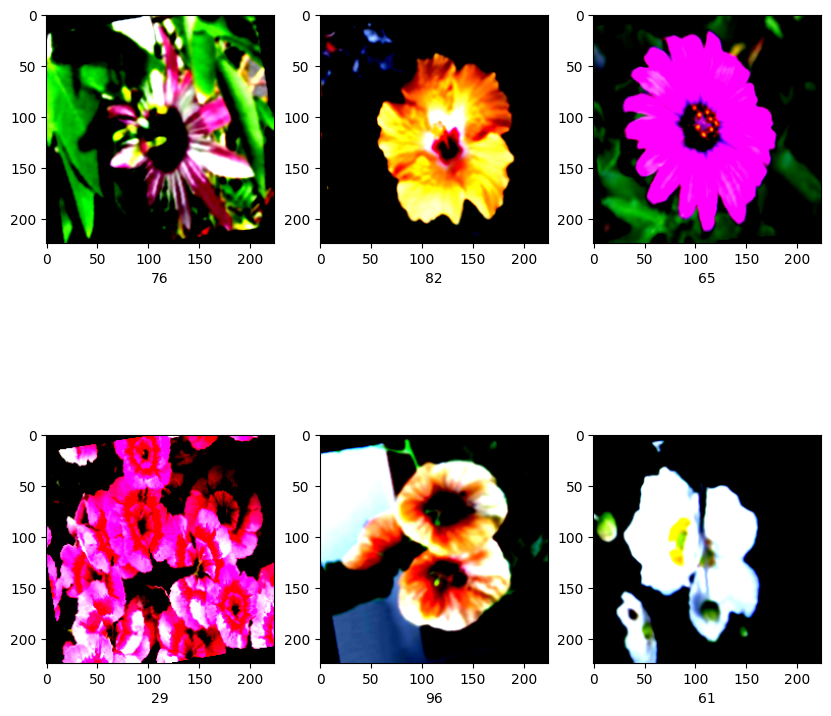

In [11]:
fig = plt.figure(figsize= (10,10))
for n , data in enumerate(train_loader):
    image = data[0]
    image = image[0].permute(1, 2, 0)
    fig.add_subplot(2 , 3 , n +1)
    plt.imshow(image)
    plt.xlabel(data[1][0].numpy())
    if n == 5:
        break
plt.show()

## Model Class

In [12]:
import torch.nn as nn
import torchvision

class Resnet50Flower102(nn.Module):
    def __init__(self, device, pretrained=True, freeze_backbone=True):
        super().__init__()
        self.device = device
        
        if pretrained:
            weights = torchvision.models.ResNet50_Weights.IMAGENET1K_V1
        else: 
            weights = None
            
        self.model = torchvision.models.resnet50(weights=weights)
            
        self.model.fc = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 102),
        )
        self.model.to(device)

    def forward(self, x):
        return self.model(x)

In [13]:
model = Resnet50Flower102(device).to(device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 227MB/s] 


# Setting up for Training
* Finding the best lr with **OneCycleLR**

Text(0, 0.5, 'Loss')

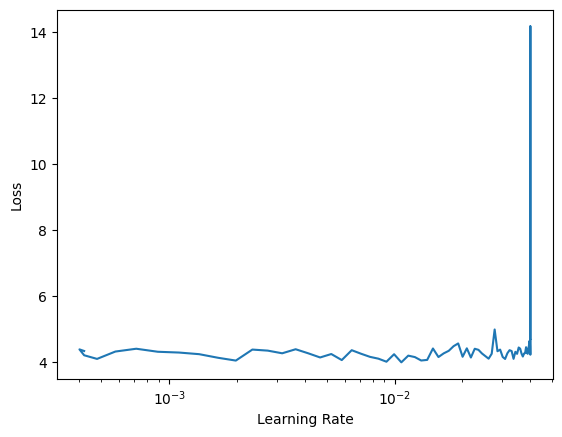

In [99]:
lr_values = []
loss_values = []
EPOCHS = 50
BATCHES = 32
total_steps = EPOCHS*BATCHES
optimizer = torch.optim.SGD(model.parameters(), lr=2e-5, momentum=0.9)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,
                  max_lr=0.04,
                  total_steps=1*32,
                  steps_per_epoch = len(train_loader),
                  epochs=EPOCHS,
                  pct_start=28/50,
                  cycle_momentum=False,
                  div_factor=1,
                  final_div_factor=100,
                  anneal_strategy ='cos')

for epoch in range(1):
    model.train()
    
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        data = data.type(torch.FloatTensor).to(device)
        target = target.to(device)
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        scheduler.step()
        lr_values.append(optimizer.param_groups[0]['lr'])
        loss_values.append(loss.item())

plt.plot(lr_values, loss_values)
plt.xscale('log')  # Use a logarithmic scale for better visualization
plt.xlabel('Learning Rate')
plt.ylabel('Loss')

In [104]:
best_lr = lr_values[loss_values.index(min(loss_values))]
best_lr

0.010710870062942883

In [14]:
model = Resnet50Flower102(device).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [15]:
def train(criterion, dataloader, show_acc=True):
    Loss = 0
    accuracy = 0
    model.train()
    for i, (image, label) in enumerate(dataloader):
        image = image.type(torch.cuda.FloatTensor)
        label = label.to(device)
        score = model(image)
        loss = criterion(score, label)
        
        Loss += loss.item()

        _, flower = score.max(1)
        correct_prediction = (flower == label).float()
        
        acc = correct_prediction.sum()/len(correct_prediction)
        
        acc *= 100
        accuracy += acc
        if i%20 == 0 and show_ac == True:
            print(flower)
            print(label)
            print(correct_prediction)
            print(acc)
        optimizer.zero_grad() 
        loss.backward()
        optimizer.step()

    accuracy = accuracy/(i+1)
    Loss = Loss/(i+1)
    return Loss, accuracy
# ac=False

def evaluate(criterion, val_dataloader, show_ac=False):
    accuracy = 0 
    Loss = 0
    
    with torch.no_grad():
        
        model.eval()
        for i , (val_image, val_label) in enumerate(val_dataloader):
            val_image = val_image.type(torch.cuda.FloatTensor)
            val_label = val_label.to(device)
            val_score = model(val_image)
            val_loss = criterion(val_score, val_label)
            Loss += val_loss.item()

            _, flower_ = val_score.max(1)
            correct_pred = (flower_ == val_label).float()

            _acc = correct_pred.sum()/len(correct_pred)

            _acc *= 100
            accuracy += _acc
            if i%20 == 0 and show_ac == True:
                print(flower_)
                print(val_label)
                print(correct_pred)
                print(_acc)
        accuracy = accuracy/(i+1)
        Loss = Loss/(i+1)
    
    return Loss, accuracy

In [16]:
EPOCHS = 60
best_accuracy = 0
summary = {
        'train_loss' : [],
        'train_acc' : [],
        'valid_loss' : [],
        'valid_acc' : []
    }
for i in range(EPOCHS):

    show_ac = False
    
    print("Epoch {}".format(i+1))
    print("LR {}".format(optimizer.param_groups[0]["lr"]))
    loss, accuracy = train(criterion, train_loader, show_ac)
    val_loss, val_accuracy = evaluate(criterion, valid_loader, show_ac)


    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        torch.save(model.state_dict(), "model.pth")

    summary["train_loss"].append(loss)
    summary["valid_loss"].append(val_loss)
    summary["train_acc"].append(accuracy)
    summary["valid_acc"].append(val_accuracy)

    print("Loss {:.4f}, Accuracy {:.4f}".format(loss, accuracy))
    print("Validation Loss {:.4f}, Validation Accuracy {:.4f}".format(val_loss, val_accuracy))

Epoch 1
LR 0.01
Loss 4.1750, Accuracy 10.7143
Validation Loss 3.3532, Validation Accuracy 24.5675
Epoch 2
LR 0.01
Loss 2.6719, Accuracy 41.9643
Validation Loss 2.0845, Validation Accuracy 53.6551
Epoch 3
LR 0.01
Loss 1.6400, Accuracy 64.6345
Validation Loss 1.5386, Validation Accuracy 62.8488
Epoch 4
LR 0.01
Loss 0.9678, Accuracy 79.4782
Validation Loss 1.1810, Validation Accuracy 72.7121
Epoch 5
LR 0.01
Loss 0.5756, Accuracy 89.0904
Validation Loss 0.9752, Validation Accuracy 75.9626
Epoch 6
LR 0.01
Loss 0.4042, Accuracy 93.1222
Validation Loss 1.0209, Validation Accuracy 75.3069
Epoch 7
LR 0.01
Loss 0.3453, Accuracy 92.8571
Validation Loss 0.8687, Validation Accuracy 77.7902
Epoch 8
LR 0.01
Loss 0.2019, Accuracy 97.0703
Validation Loss 0.9317, Validation Accuracy 76.6741
Epoch 9
LR 0.01
Loss 0.1655, Accuracy 97.3633
Validation Loss 0.8237, Validation Accuracy 78.5156
Epoch 10
LR 0.01
Loss 0.1212, Accuracy 98.3398
Validation Loss 0.7440, Validation Accuracy 80.6641
Epoch 11
LR 0.01
Lo

## Ploting Results

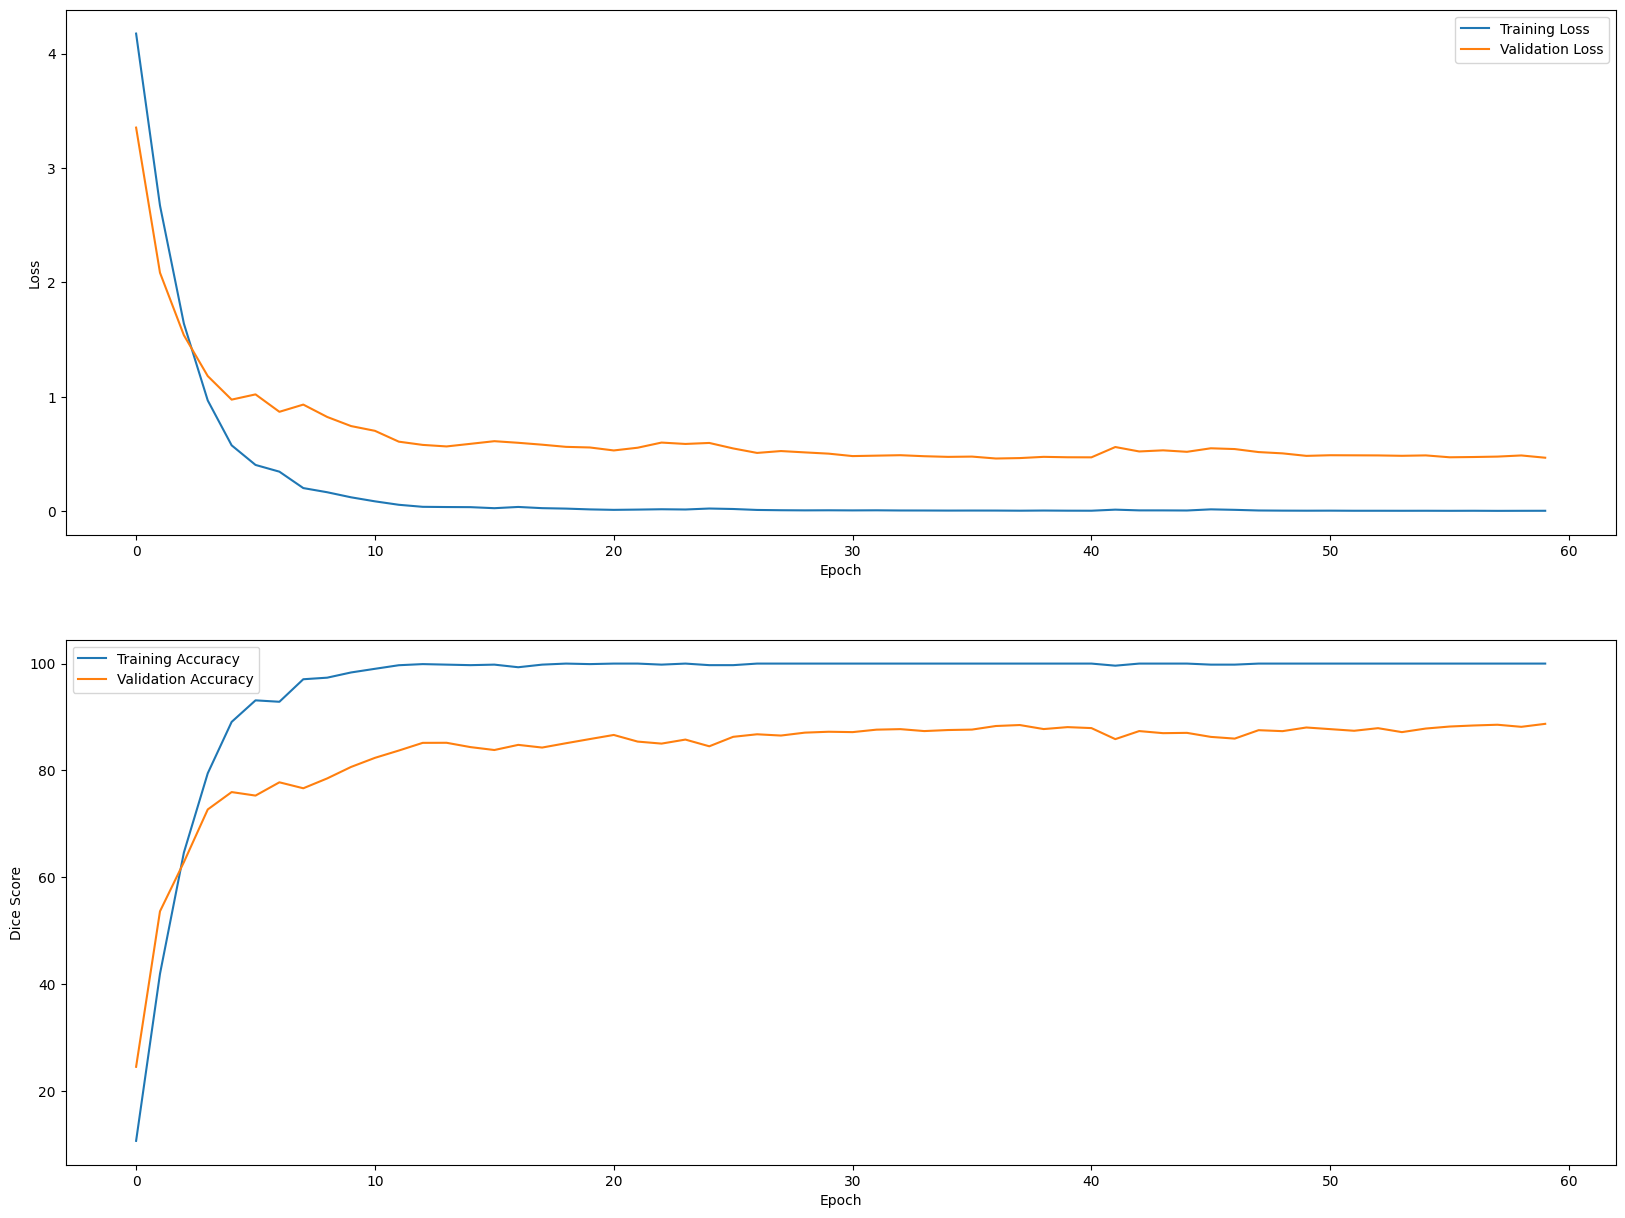

In [30]:
fig = plt.figure(figsize=(20,15))

train_loss = np.array(summary["train_loss"])
valid_loss = np.array(summary["valid_loss"])

acc= []
for i in summary["train_acc"]:
    acc.append(i.detach().cpu())
acc = np.array(acc)

val_acc = []
for i in summary["valid_acc"]:
    val_acc.append(i.detach().cpu())
val_acc = np.array(val_acc)

epochs = range(EPOCHS)

plt.subplot(2, 1, 1)
plt.plot(epochs, train_loss, label="Training Loss")
plt.plot(epochs, valid_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(epochs, acc, label="Training Accuracy")
plt.plot(epochs, val_acc, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Dice Score")
plt.legend()

In [31]:
test_data = CustomDataset(False, test_path, file_paths)
test_loader = DataLoader(test_data, batch_size=32, shuffle=True)
test_loss, test_acc = evaluate(criterion, test_loader)
print("Test: Accuracy: {} Loss: {}".format(test_acc, test_loss))

Test: Accuracy: 86.0848388671875 Loss: 0.5451653512107894


## Inference

In [33]:
classes = pd.read_csv("/kaggle/input/oxford-102-flower-name-index/oxford_flower_102_name.csv")
classes

,Index,Name
0,0,pink primrose
1,1,hard-leaved pocket orchid
2,2,canterbury bells
3,3,sweet pea
4,4,english marigold
...,...,...
97,97,mexican petunia
98,98,bromelia
99,99,blanket flower
100,100,trumpet creeper


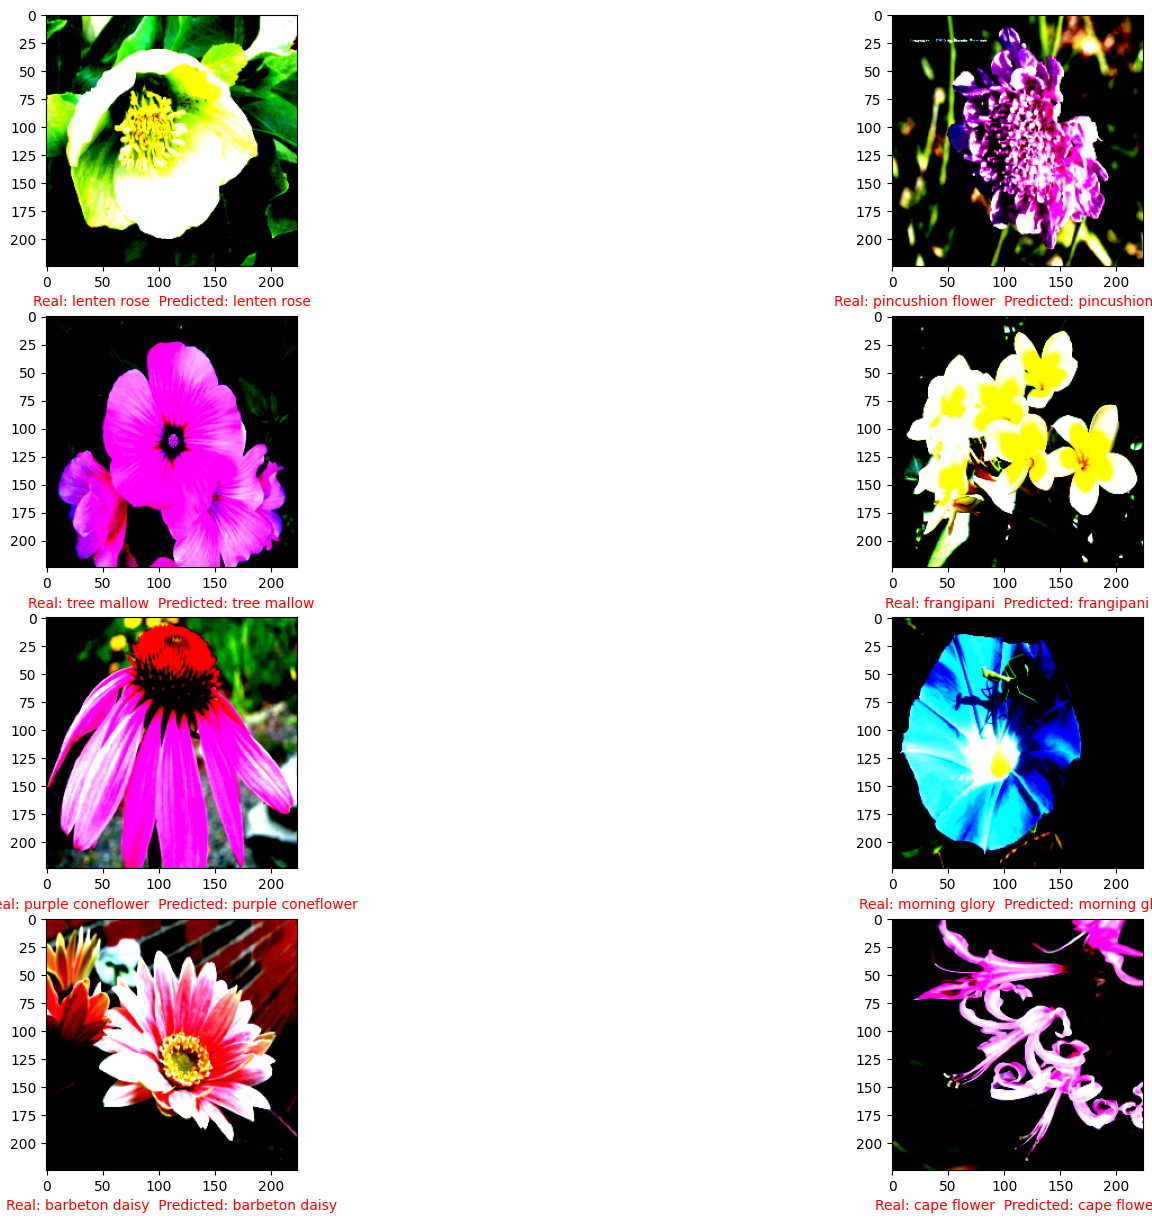

In [34]:
plt.figure(figsize=(20,15))
fig.subplots_adjust(bottom=0.8)
# test_transform = transforms.To
for i , (img, label) in enumerate(test_loader):
    if i == 8:
        break
    img = img.type(torch.FloatTensor).to(device)
    label = label.to(device)
    predict = model(img)
    _, flower = predict.max(1)
    flower = flower[0]
    
    plt.subplot(4, 2, i+1)
    plt.imshow(img[0].detach().cpu().permute(1, 2, 0))
    plt.xlabel("Real: {}  Predicted: {}".format(classes["Name"][label[0].cpu().numpy()], \
                                                classes["Name"][flower.cpu().numpy()]), color='red')